In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

We know that the ensemble vectors of the in domain data are meaningfully different than those of the out of domain data, but not /how/ they're different. In order to compare, we'll look at the individual elements of the vectors, both the distribution of their values, and the distribution of the sums of each ensemble vector value.

## Imports

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# General
import numpy as np
import pandas as pd

# Loading Data
import tensorflow_datasets as tfds

# Plots
import matplotlib.pyplot as plt

In [5]:
## Helper function to label plots
def add_headers(
    fig,
    *,
    row_headers=None,
    col_headers=None,
    row_pad=1,
    col_pad=5,
    rotate_row_headers=True,
    **text_kwargs
):
    # Based on https://stackoverflow.com/a/25814386

    axes = fig.get_axes()

    for ax in axes:
        sbs = ax.get_subplotspec()

        # Putting headers on cols
        if (col_headers is not None) and sbs.is_first_row():
            ax.annotate(
                col_headers[sbs.colspan.start],
                xy=(0.5, 1),
                xytext=(0, col_pad),
                xycoords="axes fraction",
                textcoords="offset points",
                ha="center",
                va="baseline",
                **text_kwargs,
            )

        # Putting headers on rows
        if (row_headers is not None) and sbs.is_first_col():
            ax.annotate(
                row_headers[sbs.rowspan.start],
                xy=(0, 0.5),
                xytext=(-ax.yaxis.labelpad - row_pad, 0),
                xycoords=ax.yaxis.label,
                textcoords="offset points",
                ha="right",
                va="center",
                rotation=rotate_row_headers * 90,
                **text_kwargs,
            )

## Load Data

In [6]:
res_dict = dict()
for dataset in ['mnist','kmnist','fashion_mnist']:
    res_dict[dataset] = dict()
    
    # Load the testing data
    ds, info = tfds.load(dataset, split=['train','test'], as_supervised=True, with_info=True)
    df = tfds.as_dataframe(ds[1], info)
    y_test = np.stack(df.label.values)
    
    for model_typ in ['Forest','Logistic','CNN']:
        res_dict[dataset][model_typ] = dict()
        
        # All individual classifications from ensemble components, flattened, in and out of domain.
        indi_class_in = np.array(())
        indi_class_out = np.array(())
        # The sum of each ensemble vector, in and out of domain.
        ens_sum_in = np.array(())
        ens_sum_out = np.array(())
        
        for rem in ['None'] + list(range(10)):
            pred_vector = np.load(f'{dataset}/{model_typ}/{rem}/pred_vector.npy')
            indi_class_in = np.concatenate([indi_class_in, pred_vector[y_test!=rem]], axis=None)
            indi_class_out = np.concatenate([indi_class_out, pred_vector[y_test==rem]], axis=None)
            ens_sum_in = np.concatenate([ens_sum_in, pred_vector[y_test!=rem].sum(axis=1)], axis=None)
            ens_sum_out = np.concatenate([ens_sum_out, pred_vector[y_test==rem].sum(axis=1)], axis=None)
        
        res_dict[dataset][model_typ]['indi_class_in'] = indi_class_in
        res_dict[dataset][model_typ]['indi_class_out'] = indi_class_out
        res_dict[dataset][model_typ]['ens_sum_in'] = ens_sum_in
        res_dict[dataset][model_typ]['ens_sum_out'] = ens_sum_out
            

Start by looking at the individual value distribution. We only look at Logistic and CNN classifiers, as Random Forest classifiers give binary outputs. Note the log scale y axis so areas are not going to be consistent.

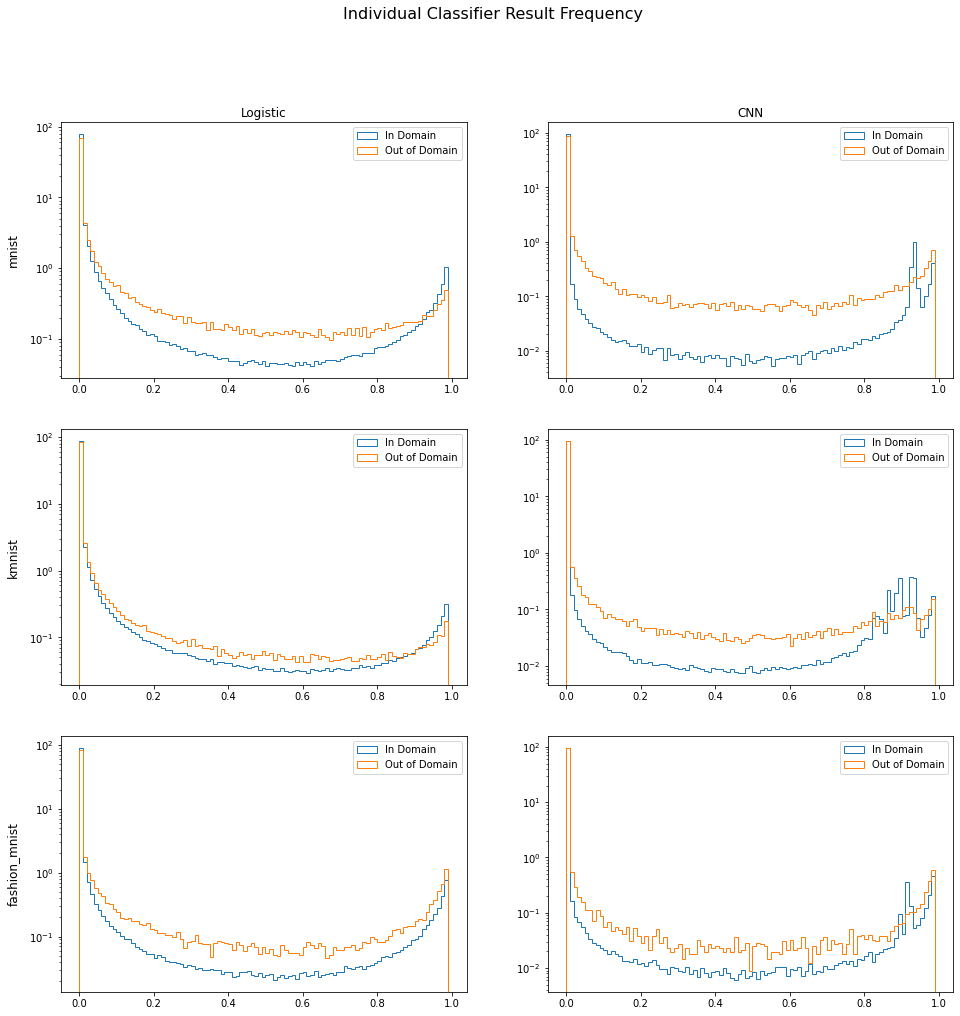

In [7]:
fig, axs = plt.subplots(3,2)

for i, dataset in enumerate(['mnist','kmnist','fashion_mnist']):
    for j, model_typ in enumerate(['Logistic','CNN']):
        axs[i,j].hist(res_dict[dataset][model_typ]['indi_class_in'], bins=np.arange(0,1,0.01), density=True, histtype='step', label='In Domain')
        axs[i,j].hist(res_dict[dataset][model_typ]['indi_class_out'], bins=np.arange(0,1,0.01), density=True, histtype='step', label='Out of Domain')
#         axs[i,j].set(title=f'{dataset}_{model_typ} Individual Classifications')
for ax in axs.flat:
    ax.set(yscale='log')
    ax.legend(loc='upper right')
#     ax.set_ylim((0,1))

    
fig.set_figwidth(16)
fig.set_figheight(16)
fig.suptitle('Individual Classifier Result Frequency', fontsize=16)
add_headers(fig, col_headers=['Logistic','CNN'], row_headers=['mnist','kmnist','fashion_mnist'], fontsize=12)


In all cases, the in domain classifications are more polarised, which is consistent with our expectation. The classifiers will be less "certain" about whether novel data belongs to their cluster or not.

Next, we look at the distribution in the sum of the ensemble classifier values. Again the log scale will make areas inconsistent. "Ideal" behavior is a strong peak at 1, the result that arrises from OHE (but not only OHE).

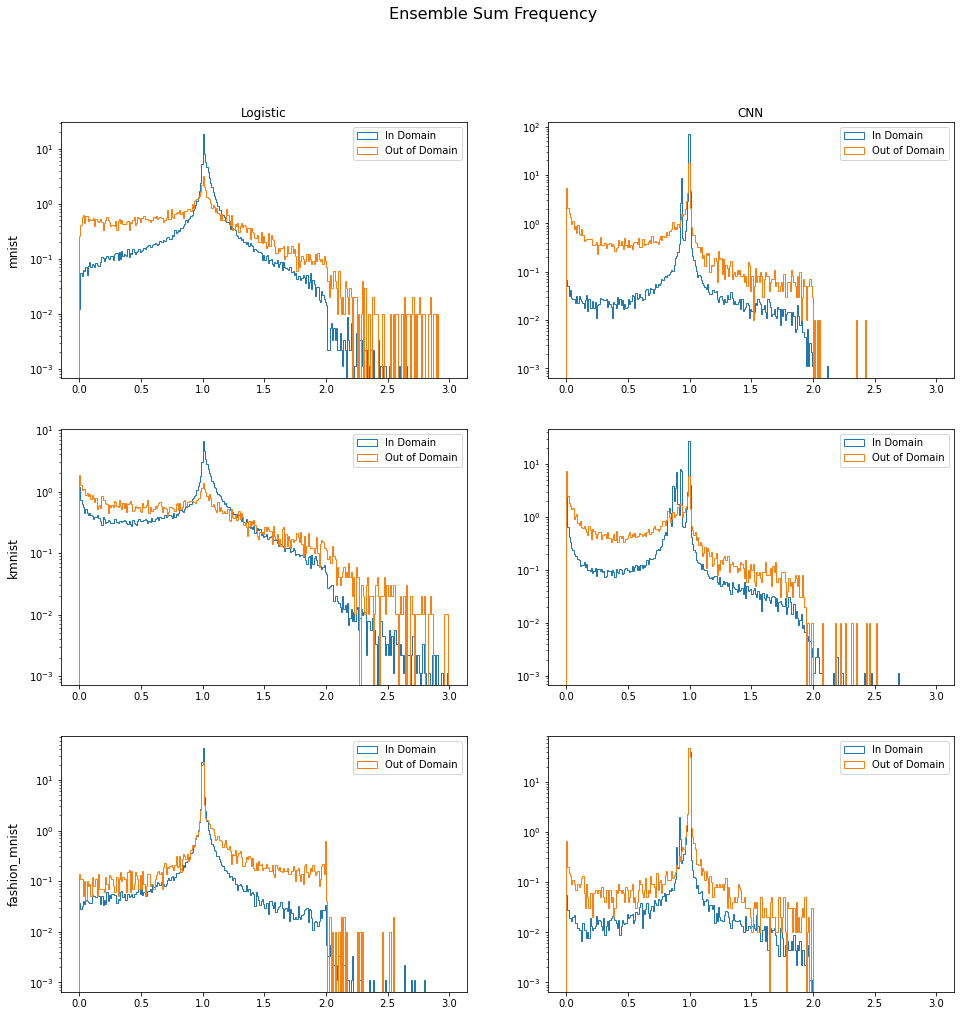

In [20]:
fig, axs = plt.subplots(3,2)

for i, dataset in enumerate(['mnist','kmnist','fashion_mnist']):
    for j, model_typ in enumerate(['Logistic','CNN']):
        axs[i,j].hist(res_dict[dataset][model_typ]['ens_sum_in'], bins=np.arange(0,3,0.01), density=True, histtype='step', label='In Domain')
        axs[i,j].hist(res_dict[dataset][model_typ]['ens_sum_out'], bins=np.arange(0,3,0.01), density=True, histtype='step', label='Out of Domain')
for ax in axs.flat:
    ax.set(yscale='log')
    ax.legend(loc='upper right')
#     ax.set_ylim((0,1))

    
fig.set_figwidth(16)
fig.set_figheight(16)
fig.suptitle('Ensemble Sum Frequency', fontsize=16)
add_headers(fig, col_headers=['Logistic','CNN'], row_headers=['mnist','kmnist','fashion_mnist'], fontsize=12)

We see the expected peak at 1 for all samples, particularly for in domain data. Remembering the log scale, a sum of less than 1 is much more common than a sum greater than 1 in most cases, except for the perenial problem child fashion mnist. This does indicate that for some datasets taking the sum as a linear indicatior of 0 -> out of domain to 1 -> in domain, but for others the more general manhattan distance from the closest OHE vector is a necessary approach to make the most of the information. we're getting from the ensemble vectors.